In [1]:
import os
import sys
import glob
import datetime
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, leastsq

### Отрисовка шаблона среднего профиля B0531+21

In [2]:
pattern = np.genfromtxt('patterns/total_profile.txt').T

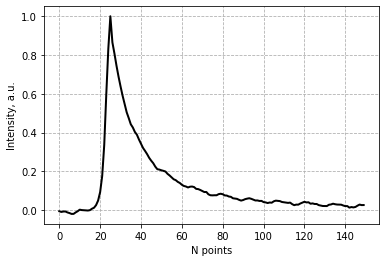

In [3]:
plt.clf()
plt.plot(pattern, 'black', lw=2)
plt.ylabel('Intensity, a.u.')
plt.xlabel('N points')
plt.grid(True, ls = '--')
plt.savefig('some_images/total_pattern.eps', format='eps')

### Отрсовка ГИ по дате и номеру 

In [182]:
date = '2015.05.19'
nomer = '0'
filename = f'results_set/file_untypized/{date}_plot_0531+21_{nomer}.csv'
pulse = np.genfromtxt(filename, skip_header=6).T

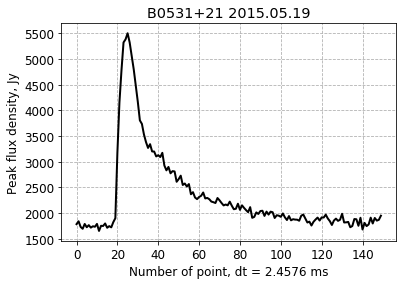

In [183]:
plt.clf()
plt.rcParams.update({'font.size': 12})
plt.title(f'B0531+21 {date}')
plt.plot(pulse + 1720, 'black', lw=2)
plt.ylabel('Peak flux density, Jy')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.grid(True, ls = '--')
plt.savefig('some_images/pulse_example.eps', format='eps')

In [184]:
np.max(pulse)

3781.416

### Отрисовка количества сеансов

In [11]:
crab_sessoins = pd.read_table('crab_session_kaz_2020-04-26.csv', sep='\t')

In [12]:
crab_sessoins

,Date,MJD,Session
0,13.02.2010,55239.833333,1
1,04.09.2010,55442.833333,1
2,05.09.2010,55443.833333,1
3,06.09.2010,55444.833333,1
4,07.09.2010,55445.833333,1
...,...,...,...
2080,10.09.2019,58735.833333,1
2081,16.09.2019,58741.833333,1
2082,17.09.2019,58742.833333,1
2083,18.09.2019,58743.833333,1


In [13]:
# разбиение по бинам
dect_res = {}
bin_size = 30

In [14]:
for idx, row in crab_sessoins.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['Session'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['Session'])

In [15]:
resul_tab = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'Sessions',
])

In [16]:
idx = 0
for key in dect_res.keys():
    resul_tab.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.sum(dect_res[key]),
    ]
    idx +=1

In [17]:
resul_tab = resul_tab.sort_values(by=['№ bin'])

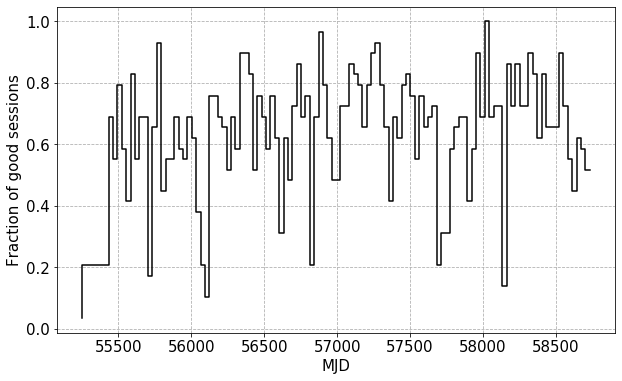

In [23]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
plt.step(resul_tab.MJD_mean, resul_tab.Sessions/resul_tab.Sessions.max(), color='black')
plt.ylabel('Fraction of good sessions')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/sessions.eps', format='eps')

### Отрисовка выплащивания сеанса

In [24]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel


def sinxx(x):
    return (np.sin(x)/x)**2


def beam_obs(x, amp,  shift, y0):
    return amp*(np.sin(x + shift)/(x + shift))**2 + y0


if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"

elif 'Linux' in platform.platform():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"

else:
    print('unknown system', platform.platform(), platform.release())

sys.path.append(PACK_DIR)
from PRAO import *

In [25]:
files_0531 = glob.glob(f'{ALL_DATA}0531+21{os.sep}*{os.sep}*{os.sep}*_profiles.txt')
print(f'Main object: 0531+21; Numbers of files: {len(files_0531)}')

# установка диапазона дат
date_start = datetime.datetime(2009, 11, 20, 0, 0)
data_stop = datetime.datetime(2019, 11, 18, 0, 0)

main_set = [x for x in files_0531
             if date_start <= datetime.datetime.strptime(os.path.basename(x)[:6], '%d%m%y') <= data_stop]
print(f'Main set: 0531+21; Numbers of files: {len(main_set)}')

Main object: 0531+21; Numbers of files: 3040
Main set: 0531+21; Numbers of files: 3040


In [26]:
date = '190515_'
file = [i for i in main_set if date in i][0]

In [27]:
head, main_pulse, data_pulses, back = read_profiles_MD(file)
day, month, year = head['date'].split('.')
            
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)

fullpoints = int(head['numpuls'])*int(head['numpointwin'])
x = np.linspace(-1.37, 1.37, fullpoints)

obspoints = fullpoints - int(head['numpointwin'])

y = sinxx(x[:obspoints])
x = x[:obspoints]

poli = flatter(obser, 4)
max_calib = max(poli)
amp = max_calib
shift = 0
y0 = 50
popt,pcov = curve_fit(beam_obs,x,obser,p0=[amp,shift, y0])

beam_coeff = beam_obs(x,*popt)
coeff = 1720/(amp - popt[2])
obser_calib = coeff*obser
y0_back = popt[2]*coeff

cor_d = []
for data_point, coeff in zip(obser_calib, beam_coeff/np.max(beam_coeff)):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)
cor_d -= y0_back

poli_13 = flatter(cor_d, 13)
flat_obser = (cor_d - poli_13) + np.median(cor_d)  # Калибровка
med_flat_obser = np.median(flat_obser)

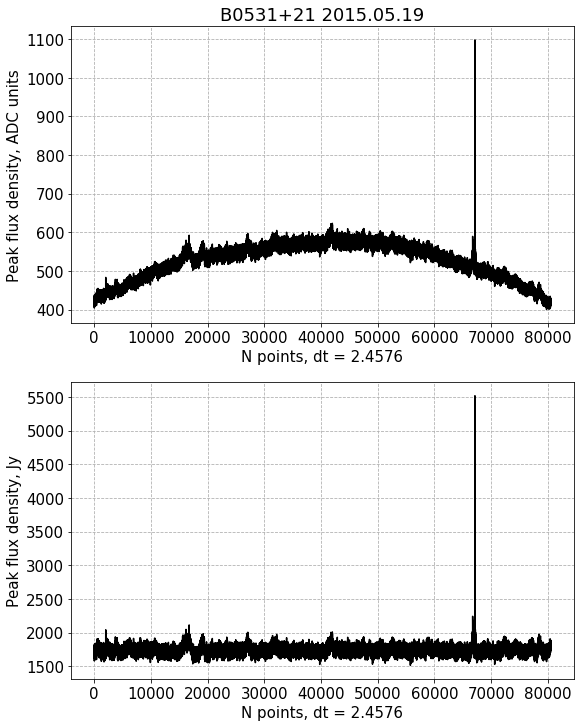

In [28]:
plt.close()
plt.figure(figsize=(9, 12))
plt.subplot(211)
plt.title(f'B0531+21 {year}.{month}.{day}')
plt.plot(obser, color='black')
plt.grid(True, ls='--')
plt.ylabel('Peak flux density, ADC units')
plt.xlabel(f"N points, dt = {head['tay']}")
plt.subplot(212)
plt.plot(flat_obser, color='black')
plt.ylabel('Peak flux density, Jy')
plt.xlabel(f"N points, dt = {head['tay']}")
plt.grid(True, ls='--')
plt.savefig('some_images/one_session.eps', format='eps')

### Отрисовка темпа генерации

In [29]:
gp_table = pd.read_csv('crab_gp_kaz_pulses_2020-04-26.csv', sep='\t')

In [30]:
gp_table['gp'] = 1

In [49]:
gp_table = gp_table[:8831] # Отсечка по 58700

In [50]:
# разбиение по бинам
dect_res = {}
bin_size = 30

In [51]:
for idx, row in gp_table.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['gp'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['gp'])

In [52]:
resul_gp = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'gp',
])

In [53]:
idx = 0
for key in dect_res.keys():
    resul_gp.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.sum(dect_res[key]),
    ]
    idx +=1

In [54]:
resul_gp = resul_gp.sort_values(by=['№ bin'])

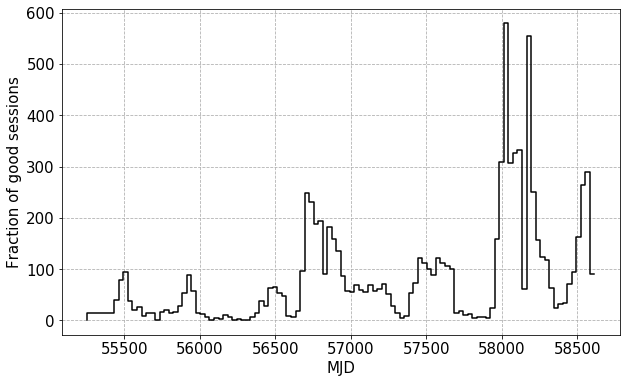

In [55]:
plt.figure(figsize=(10,6))
plt.step(resul_gp.MJD_mean, resul_gp.gp, color='black')
plt.ylabel('Fraction of good sessions')
plt.xlabel('MJD')
plt.grid(True, ls='--')
#plt.savefig('some_images/sessions.eps', format='eps')

In [56]:
resul_tab['time_observation'] = resul_tab['Sessions']*3.3841152

In [57]:
resul_gp['rate'] = resul_gp['gp']/resul_tab['time_observation']

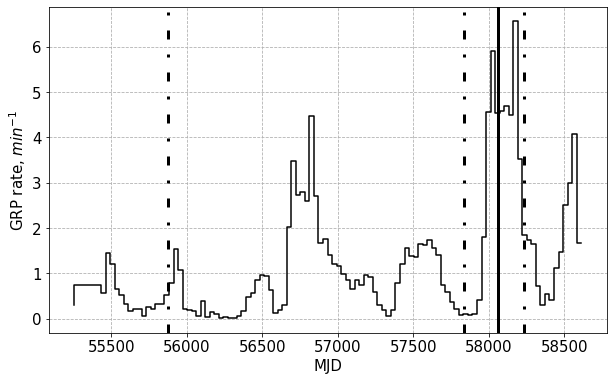

In [58]:
plt.figure(figsize=(10,6))
plt.step(resul_gp.MJD_mean, resul_gp.rate, color='black')
plt.ylabel(r'GRP rate, $min^{-1}$')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate.eps', format='eps')

### Отрисовка логарифма пиковой плотности потока по регионам

In [59]:
gp_table['Time_series'] = pd.to_datetime(gp_table['Date'], format='%d.%m.%Y', errors='ignore')
gp_table = gp_table.set_index('Time_series')

/home/andr/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
# Зона 1 56600, 57100  : '2013-11-04':'2015-03-19'
# Зона 2 57900, 58350  : '2017-05-27':'2018-08-20'
# Зона 3 58425, 58750  : '2018-11-03':'2019-09-19'
# off-region : '2014-01-01':'2013-11-04', '2015-03-19':'2017-05-27', '2018-08-20':'2018-11-03'
gp_table_zone_1 = gp_table['2013-11-04':'2015-03-19']
gp_table_zone_2 = gp_table['2017-05-27':'2018-08-20']
gp_table_zone_3 = gp_table['2018-11-03':'2019-09-19']
off_zone_1 = gp_table['2010-02-13':'2013-11-03']
off_zone_2 = gp_table['2015-03-20':'2017-05-28']
off_zone_3 = gp_table['2018-08-21':'2018-11-02']
off_zone = pd.concat([off_zone_1, off_zone_2, off_zone_3])

In [62]:
print(len(gp_table_zone_1),
     len(gp_table_zone_2),
     len(gp_table_zone_3),
     len(off_zone))

1892 3363 993 2584


In [63]:
log_S_1 = [np.log10(i) for i in gp_table_zone_1['amp of gp, Jy']]
log_S_2 = [np.log10(i) for i in gp_table_zone_2['amp of gp, Jy']]
log_S_3 = [np.log10(i) for i in gp_table_zone_3['amp of gp, Jy']]
log_S_off = [np.log10(i) for i in off_zone['amp of gp, Jy']]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

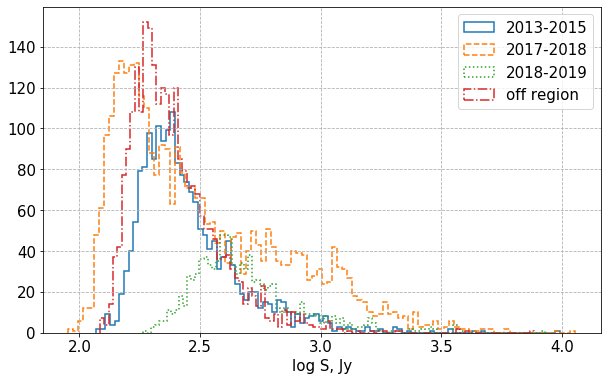

In [70]:
plt.clf()
plt.figure(figsize=(10,6))
plt.xlabel('log S, Jy')
plt.hist(log_S_1, bins=100, fc='none', lw=1.5, histtype='step', ls='-', label='2013-2015')
plt.hist(log_S_2, bins=100, fc='none', lw=1.5, histtype='step', ls='--', label='2017-2018')
plt.hist(log_S_3, bins=100, fc='none', lw=1.5, histtype='step', ls=':', label='2018-2019')
plt.hist(log_S_off, bins=100, fc='none', lw=1.5, histtype='step', ls='-.', label='off region')
plt.grid(True, ls='--')
plt.legend()
plt.savefig('some_images/peak_flux_dstb.eps', format='eps')

In [71]:
log_F_1 = [np.log10(i) for i in gp_table_zone_1['E_fit_func, Jy*ms'] if round(i, 2) > 0]
log_F_2 = [np.log10(i) for i in gp_table_zone_2['E_fit_func, Jy*ms']  if round(i, 2) > 0]
log_F_3 = [np.log10(i) for i in gp_table_zone_3['E_fit_func, Jy*ms']  if round(i, 2) > 0]
log_F_off = [np.log10(i) for i in off_zone['E_fit_func, Jy*ms']  if round(i, 2) > 0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

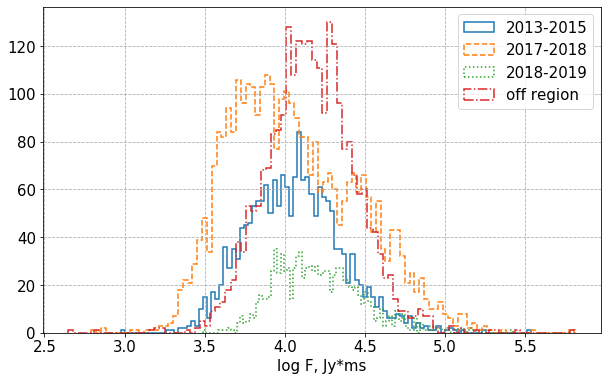

In [72]:
plt.clf()
plt.figure(figsize=(10,6))
plt.xlabel('log F, Jy*ms')
plt.hist(log_F_1, bins=100, fc='none', lw=1.5, histtype='step', ls='-', label='2013-2015')
plt.hist(log_F_2, bins=100, fc='none', lw=1.5, histtype='step', ls='--', label='2017-2018')
plt.hist(log_F_3, bins=100, fc='none', lw=1.5, histtype='step', ls=':', label='2018-2019')
plt.hist(log_F_off, bins=100, fc='none', lw=1.5, histtype='step', ls='-.', label='off region')
plt.grid(True, ls='--')
plt.legend()
plt.savefig('some_images/fluence_dstb.eps', format='eps')

### Отрисовка энергии по регионам c отсечкой по энергии

In [73]:
gp_table_cut_E = gp_table[gp_table['E_fit_func, Jy*ms'] > 10000]

In [74]:
# разбиение по бинам
dect_res = {}
bin_size = 30

In [75]:
for idx, row in gp_table_cut_E.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['gp'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['gp'])

In [80]:
resul_gp = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'gp',
])

In [81]:
resul_gp = resul_gp.sort_values(by=['№ bin'])

In [82]:
idx = 0
for key in dect_res.keys():
    resul_gp.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.sum(dect_res[key]),
    ]
    idx +=1

In [83]:
resul_gp['rate'] = resul_gp['gp']/resul_tab['time_observation']

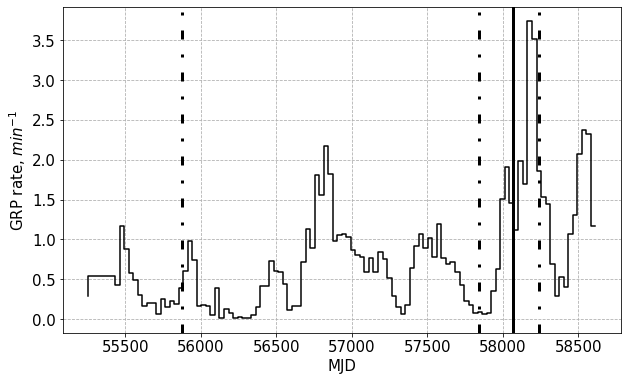

In [84]:
plt.figure(figsize=(10,6))
plt.step(resul_gp.MJD_mean, resul_gp.rate, color='black')
plt.ylabel(r'GRP rate, $min^{-1}$')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate_cut_E.eps', format='eps')

In [85]:
gp_table_zone_1_cut_E = gp_table_cut_E['2013-11-04':'2015-03-19']
gp_table_zone_2_cut_E = gp_table_cut_E['2017-05-27':'2018-08-20']
gp_table_zone_3_cut_E = gp_table_cut_E['2018-11-03':'2019-09-19']
off_zone_1_cut_E = gp_table_cut_E['2010-02-13':'2013-11-03']
off_zone_2_cut_E = gp_table_cut_E['2015-03-20':'2017-05-28']
off_zone_3_cut_E = gp_table_cut_E['2018-08-21':'2018-11-02']
off_zone_cut_E = pd.concat([off_zone_1_cut_E, off_zone_2_cut_E, off_zone_3_cut_E])

In [86]:
print(len(gp_table_zone_1_cut_E),
     len(gp_table_zone_2_cut_E),
     len(gp_table_zone_3_cut_E),
     len(off_zone_cut_E))

1063 1703 742 1881


In [88]:
log_S_1_cut_E = [np.log10(i) for i in gp_table_zone_1_cut_E['amp of gp, Jy']]
log_S_2_cut_E = [np.log10(i) for i in gp_table_zone_2_cut_E['amp of gp, Jy']]
log_S_3_cut_E = [np.log10(i) for i in gp_table_zone_3_cut_E['amp of gp, Jy']]
log_S_off_cut_E = [np.log10(i) for i in off_zone_cut_E['amp of gp, Jy']]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

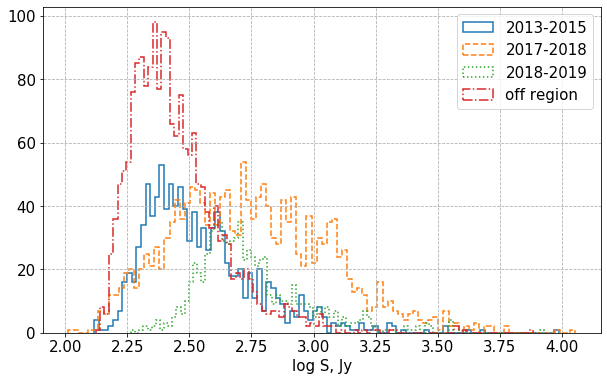

In [89]:
plt.clf()
plt.figure(figsize=(10,6))
plt.xlabel('log S, Jy')
plt.hist(log_S_1_cut_E, bins=100, fc='none', lw=1.5, histtype='step', ls='-', label='2013-2015')
plt.hist(log_S_2_cut_E, bins=100, fc='none', lw=1.5, histtype='step', ls='--', label='2017-2018')
plt.hist(log_S_3_cut_E, bins=100, fc='none', lw=1.5, histtype='step', ls=':', label='2018-2019')
plt.hist(log_S_off_cut_E, bins=100, fc='none', lw=1.5, histtype='step', ls='-.', label='off region')
plt.grid(True, ls='--')
plt.legend()
plt.savefig('some_images/peak_flux_dstb_cut_E.eps', format='eps')

In [90]:
log_F_1 = [np.log10(i) for i in gp_table_zone_1_cut_E['E_fit_func, Jy*ms']]
log_F_2 = [np.log10(i) for i in gp_table_zone_2_cut_E['E_fit_func, Jy*ms']]
log_F_3 = [np.log10(i) for i in gp_table_zone_3_cut_E['E_fit_func, Jy*ms']]
log_F_off = [np.log10(i) for i in off_zone_cut_E['E_fit_func, Jy*ms']]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

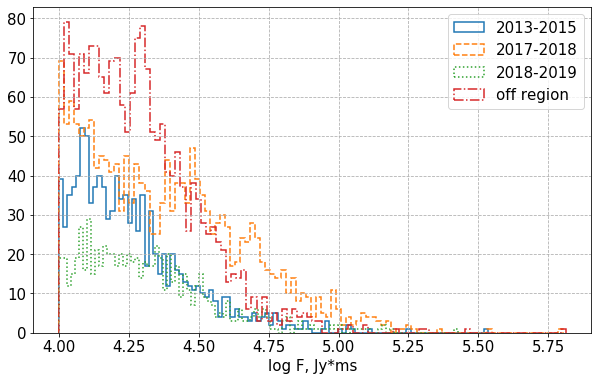

In [91]:
plt.clf()
plt.figure(figsize=(10,6))
plt.xlabel('log F, Jy*ms')
plt.hist(log_F_1, bins=100, fc='none', lw=1.5, histtype='step', ls='-', label='2013-2015')
plt.hist(log_F_2, bins=100, fc='none', lw=1.5, histtype='step', ls='--', label='2017-2018')
plt.hist(log_F_3, bins=100, fc='none', lw=1.5, histtype='step', ls=':', label='2018-2019')
plt.hist(log_F_off, bins=100, fc='none', lw=1.5, histtype='step', ls='-.', label='off region')
plt.grid(True, ls='--')
plt.legend()
plt.savefig('some_images/fluence_dstb_cut_E.eps', format='eps')

### Отрисовка логарифма потока и энергии за все дни

<Figure size 432x288 with 0 Axes>

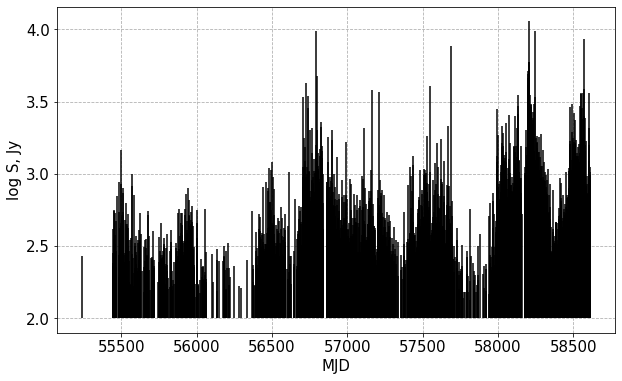

In [92]:
plt.clf()
plt.figure(figsize=(10,6))
plt.ylabel('log S, Jy')
plt.xlabel('MJD')
plt.vlines(gp_table_cut_E['MJD'], [2], np.log10(gp_table_cut_E['amp of gp, Jy']))
plt.grid(True, ls='--')
plt.savefig('some_images/flux_cut_E.eps', format='eps')

<Figure size 432x288 with 0 Axes>

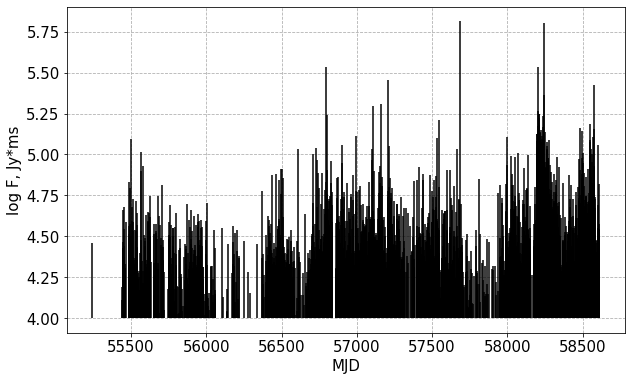

In [93]:
plt.clf()
plt.figure(figsize=(10,6))
plt.ylabel('log F, Jy*ms')
plt.xlabel('MJD')
plt.vlines(gp_table_cut_E['MJD'], [4], np.log10(gp_table_cut_E['E_fit_func, Jy*ms']))
plt.grid(True, ls='--')
plt.savefig('some_images/fluence_cut_E.eps', format='eps')

### Отрисовка рассеяния

In [146]:
dect_res = {}
bin_size = 30

In [147]:
gp_table.columns

Index(['Date', 'Time start', 'MJD', 'Median, Jy', 'amp of gp, Jy',
       'W50, point', 'W10, point', 'W50_19D_poly, point',
       'W10_19D_poly, point', 'W50_fit_func, point', 'W10_fit_func, point',
       'E_19D_poly, Jy*ms', 'E_fit_func, Jy*ms', 'Tay, ms', 'STD, Jy', 'gp'],
      dtype='object')

In [148]:
for idx, row in gp_table.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)

In [149]:
resul_tab = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'W50_mean',
    'STD',
    'len bin'])

In [150]:
idx = 0
for key in dect_res.keys():
    resul_tab.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.mean(dect_res[key]),
        np.std(dect_res[key]),
        np.size(dect_res[key])
    ]
    idx +=1

In [151]:
resul_tab = resul_tab.sort_values(by=['№ bin'])

In [152]:
resul_tab.head()

,№ bin,MJD_mean,W50_mean,STD,len bin
0,0.0,55253.0,157.207678,0.000000,1.0
1,6.0,55433.0,108.768264,53.196740,15.0
2,7.0,55463.0,95.324996,44.775486,39.0
3,8.0,55493.0,87.993647,58.426530,78.0
4,9.0,55523.0,86.328239,47.555233,94.0


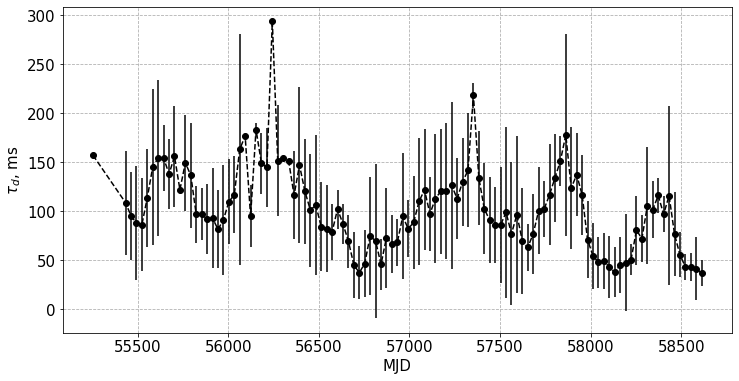

In [153]:
plt.figure(figsize=(12,6))
plt.errorbar(resul_tab.MJD_mean, resul_tab['W50_mean'],
             yerr=resul_tab['STD'], color='black', fmt='--o')
plt.ylabel(r'$\tau_d$, ms')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter.eps', format='eps')

## Отрисовка рассеяние + другие графики

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


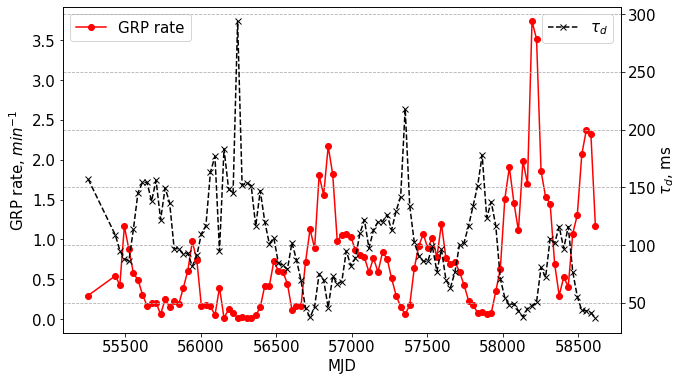

In [172]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(resul_gp.MJD_mean, resul_gp.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab.MJD_mean, resul_tab['W50_mean'], 'xb--', color='black', label=r'$\tau_d$')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'$\tau_d$, ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter+gp_rate.eps', format='eps')

In [138]:
dect_res = {}
bin_size = 30

for idx, row in gp_table_cut_E.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['E_fit_func, Jy*ms'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['E_fit_func, Jy*ms'])
        
resul_tab_cut_E = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'E_mean'
])

idx = 0
for key in dect_res.keys():
    resul_tab_cut_E.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.mean(dect_res[key])
    ]
    idx +=1

resul_tab_cut_E = resul_tab_cut_E.sort_values(by=['№ bin'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


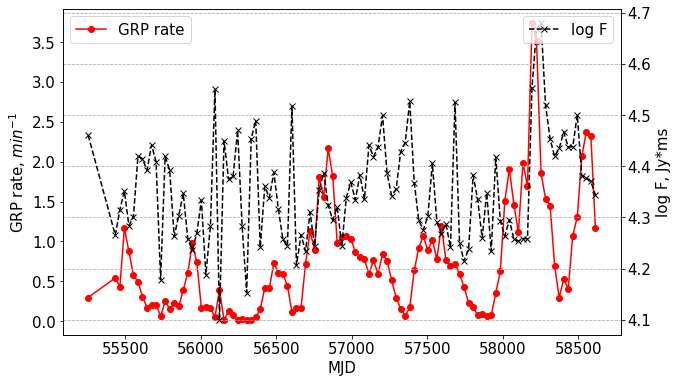

In [173]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(resul_gp.MJD_mean, resul_gp.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab_cut_E.MJD_mean, np.log10(resul_tab_cut_E.E_mean),
         'xb--', color='black', label='log F')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'log F, Jy*ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate+fluence_mean_bin_30.eps', format='eps')

In [142]:
dect_res = {}
bin_size = 30

for idx, row in gp_table_cut_E.iterrows():
    bin_num = (row['MJD'] - 55238)//bin_size
    try:
        dect_res[bin_num].append(row['amp of gp, Jy'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['amp of gp, Jy'])
        
resul_tab_cut_I = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'I_mean'
])

idx = 0
for key in dect_res.keys():
    resul_tab_cut_I.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + 55238,
        np.mean(dect_res[key])
    ]
    idx +=1

resul_tab_cut_I = resul_tab_cut_I.sort_values(by=['№ bin'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


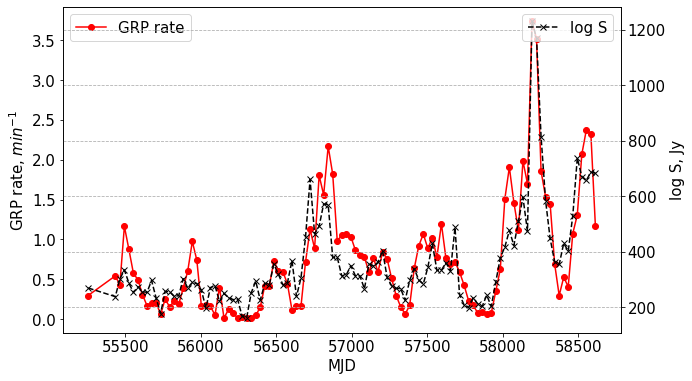

In [174]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(resul_gp.MJD_mean, resul_gp.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab.MJD_mean, resul_tab_cut_I.I_mean,
         'xb--', color='black', label='log S')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel('log S, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate+flux_mean_bin_30.eps', format='eps')

In [106]:
resul_tab.to_csv('time_scatterig_bin30_kaz.csv', sep=',', header=True, index=True)

In [107]:
resul_gp.to_csv('gp_rate_bin30_kaz.csv', sep=',', header=True, index=True)